# Demo3 - より高精度なモデルを使った学習

In [9]:
import numpy as np
import tensorflow as tf
import tfgraphviz as tfg
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
%matplotlib inline

## 1. データの準備

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Data Info
         value
-----  -------
train    55000
test     10000


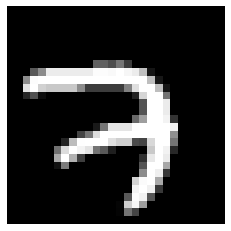

In [29]:
# データの準備
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# データの情報表示
data_info = [
    ['train', mnist.train.images.shape[0]],
    ['test', mnist.test.images.shape[0]]
]

print('\nData Info')
print(tabulate.tabulate(data_info, ['value']))

# 1枚画像を表示する
sns.set_style('dark')
plt.tick_params(labelbottom="off")
plt.tick_params(labelleft="off")
plt.imshow(mnist.train.images[0].reshape([28, 28]))
plt.gray()

In [11]:
def weight_variable(shape):
    init = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init)

def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

def conv2d(x, W, b):
    conv2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv2d + b)

def max_pool2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

## 2. モデルの構築

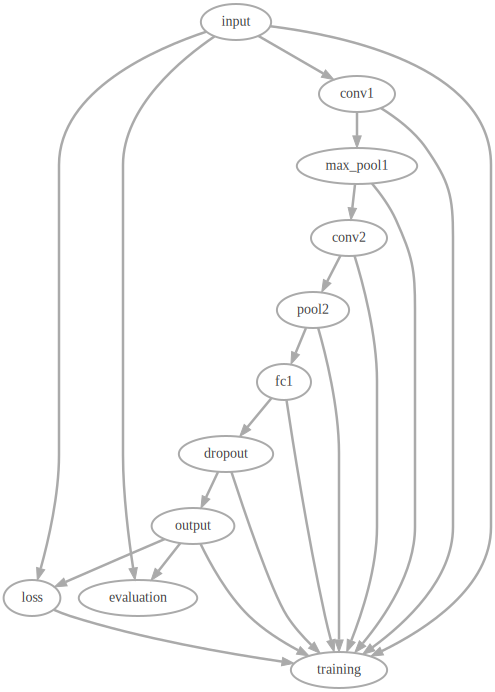

In [12]:
tf.reset_default_graph()
g = tf.get_default_graph()

# ネットワークの構築
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 28*28])
    y_ = tf.placeholder(tf.float32, [None, 10])
    x_image = tf.reshape(x, [-1, 28, 28, 1])
with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = conv2d(x_image, W_conv1, b_conv1)

with tf.name_scope('max_pool1'):
    h_pool1 = max_pool2x2(h_conv1)

with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = conv2d(h_pool1, W_conv2, b_conv2)

with tf.name_scope('pool2'):
    h_pool2 = max_pool2x2(h_conv2)

with tf.name_scope('fc1'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])

    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_dropout = tf.nn.dropout(h_fc1, keep_prob)

with tf.name_scope('output'):
    W2 = weight_variable([1024, 10])
    b2 = bias_variable([10])

    output = tf.matmul(h_fc1_dropout, W2) + b2

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_))

with tf.name_scope('training'):
    train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
tfg.board(g, depth=1, style=True)

## 3. 学習 + 評価

In [13]:
# tensorflowのセッションの開始
sess = tf.InteractiveSession()

# 設定したtensorflowの変数や定数を初期化
sess.run(tf.global_variables_initializer())

train_accs   = []
train_losses = []
test_accs    = []
test_losses  = []
temp_train_accs = []
temp_train_losses = []

max_step = 10000

# 学習の開始
for step in tqdm_notebook(range(1, max_step + 1)):
    # 50個ずつ画像とラベルをトレーニングデータセットから抽出する
    batch_x, batch_y = mnist.train.next_batch(50)
    feed_dict = {x: batch_x, y_:batch_y, keep_prob: 0.5}
    
    # 上記で抽出したトレーニングデータ・セットで学習させる
    sess.run(train_op, feed_dict=feed_dict)
    
    # 損失と正解率を測定
    train_acc, train_loss = sess.run([accuracy, loss], feed_dict={x: batch_x, y_:batch_y, keep_prob: 1.0})
    temp_train_accs.append(train_acc)
    temp_train_losses.append(train_loss)
    
    # 200 ステップに1回テストデータ・セットに対する損失と正解率を測定する
    if step % 20 == 0:
        test_x, test_y = mnist.test.next_batch(100)
        test_acc, test_loss = sess.run([accuracy, loss], feed_dict={x: test_x, y_: test_y, keep_prob: 1.0})
        mean_train_accs = np.mean(temp_train_accs)
        mean_train_losses = np.mean(temp_train_losses)
        train_accs.append(mean_train_accs)
        train_losses.append(mean_train_losses)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        temp_train_accs = []
        temp_train_losses = []
        
test_x, test_y = mnist.test.images, mnist.test.labels
test_acc, test_loss = sess.run([accuracy, loss], feed_dict={x:test_x, y_:test_y, keep_prob: 1.0})
print("test accuracy: %.5f" % test_acc)
print("test loss: %.5g" % test_loss)



test accuracy: 0.99160
test loss: 0.025537


### demo3の結果

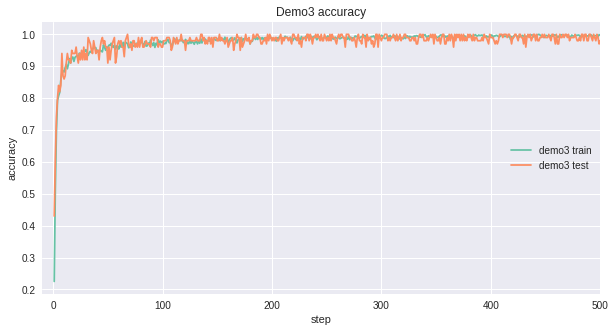

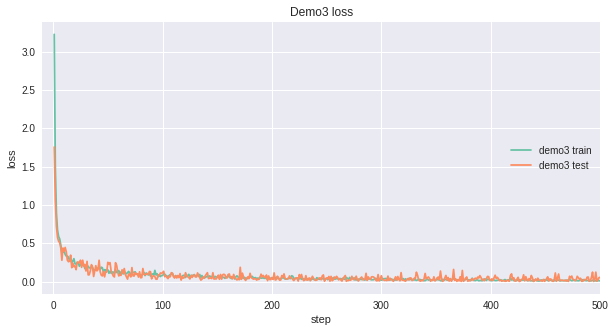

In [28]:
# グラフの表示
## 正解率
colors = sns.color_palette("Set2", 10)
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
xvalues = np.arange(1, len(train_accs) + 1)
ax.plot(xvalues, train_accs, label='demo3 train', color=colors[8])
ax.plot(xvalues, test_accs, label='demo3 test', color=colors[9])
ax.set_xlim(-10, 500)
ax.set_xlabel("step")
ax.set_ylabel("accuracy")
plt.legend(loc='center right')
ax.set_title('Demo3 accuracy')

## 損失
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
xvalues = np.arange(1, len(train_losses) + 1)
ax.plot(xvalues, train_losses, label='demo3 train', color=colors[8])
ax.plot(xvalues, test_losses, label='demo3 test', color=colors[9])
ax.set_xlim(-10, 500)
ax.set_xlabel("step")
ax.set_ylabel("loss")
plt.legend(loc='center right')
ax.set_title('Demo3 loss')

## 推論

予測: 9


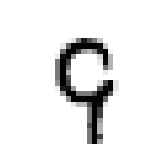

In [15]:
# 推論する
test_image_index = 6
test_image_no = mnist.test.labels[test_image_index].argmax() + 1
test_image_data = mnist.test.images[test_image_index]
result = sess.run(output, feed_dict={x: [test_image_data], keep_prob: 1.0})

sns.set_style('dark')
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(2, 1, 1)
ax.imshow(test_image_data.reshape([28, 28]))
ax.tick_params(labelbottom='off')
ax.tick_params(labelleft='off')

print("予測: %d" % result.argmax())

In [16]:
# 結果データをnp形式で保存
np.savez('demo3_result.npz', train_accs=train_accs, train_losses=train_losses, test_accs=test_accs, test_losses=test_losses)